# Model Building

putting it all togather

## Setting up

In [64]:
import os, sys
import random
import warnings

import logging
# logging.basicConfig(filename='modeling.log', filemode='a', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger()
handler = logging.FileHandler('modeling.log', mode='a')
formatter = logging.Formatter('%(name)s - %(levelname)s - %(asctime)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.log(logging.INFO, 'Started modeling.py')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#For the plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn import set_config

set_config(display="diagram")

set random reed

In [65]:
random_state = 42
# np.random.seed = random_state
rng = np.random.default_rng(random_state)

In [66]:
train = pd.read_csv('../data/processed/train.csv')
train.drop(['id'], inplace=True, axis=1)

test = pd.read_csv('../data/processed/test.csv')
test.drop(['id'], inplace=True, axis=1)

## Importing Data

In [67]:
col_y = 'song_popularity'

X = train.copy()
y = X.pop(col_y)

In [68]:
mask = X.nunique() < 15
categorical_cols = X.columns[mask]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [69]:
# convert audio_mode, key & time_signature column values to categorical
X['key'] = X['key'].astype( "Int64")
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  35899 non-null  float64
 1   acousticness      36008 non-null  float64
 2   danceability      35974 non-null  float64
 3   energy            36025 non-null  float64
 4   instrumentalness  36015 non-null  float64
 5   liveness          35914 non-null  float64
 6   loudness          36043 non-null  float64
 7   speechiness       40000 non-null  float64
 8   tempo             40000 non-null  float64
 9   audio_valence     40000 non-null  float64
 10  key_0             40000 non-null  uint8  
 11  key_1             40000 non-null  uint8  
 12  key_2             40000 non-null  uint8  
 13  key_3             40000 non-null  uint8  
 14  key_4             40000 non-null  uint8  
 15  key_5             40000 non-null  uint8  
 16  key_6             40000 non-null  uint8 

# Splitting data

In [70]:
# split the dataset in train, validation & test sets
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=random_state, stratify=y_train_full)

In [71]:
X_train_full.shape, X_train.shape, X_val.shape, X_test.shape

((32000, 28), (25600, 28), (6400, 28), (8000, 28))

## Importing modeling & pre/post-processing libraries

In [72]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator, IterativeImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, RobustScaler, power_transform, minmax_scale
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report

# todo: use fit_resample & FunctionTransformer to implement outlier removal
# # from imblearn.pipeline import Pipeline
# # from imblearn import FunctionSampler

# import classifier models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegressionCV, SGDClassifier, SGDRegressor, Ridge, LassoLarsCV, LassoLars, RidgeCV, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# sys.path.append("kuma_utils/")
# from kuma_utils.preprocessing.imputer import LGBMImputer

## building Preprocessors

In [90]:
# columns used for inverse sigmoid transformation
from sklearn.preprocessing import MinMaxScaler, minmax_scale, PowerTransformer, FunctionTransformer
# from sklearn_pandas import DataFrameMapper

col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]

col_pow = [
    'song_duration_ms',
    'tempo',
]

# make a custom transformer to transform the data
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin

class PreProcessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, show_impute=False, inplace=False):
        self.show_impute = show_impute
        self.inplace = inplace
        self.col_sig, self.col_pow, self.loudness = cols
        self.cols = self.col_sig + self.col_pow
        self.inv_sigmoid = FunctionTransformer(lambda x: np.log(x / (1-x)))
        self.loudness_transformer = FunctionTransformer(lambda x: np.log1p(-x))
        
    def fit(self, X, y=None):
        # if type(X) is tuple:
        #     X = X[0]
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)
        # logger.log(logging.INFO, f'Fitting PreProcessorTransformer: type of X is {type(X)}, type of y is {type(y)}')

        self.scaler = MinMaxScaler(feature_range=(0+1e-6, 1-1e-6)).fit(X[self.col_sig], y=y)
        
        X_tmp = X[self.col_sig+self.col_pow].copy()
        X_tmp[self.col_sig] = self.scaler.transform(X_tmp[self.col_sig])
        X_tmp[self.col_sig] = self.inv_sigmoid.fit_transform(X_tmp[self.col_sig], y=y)
        
        self.transformer = PowerTransformer().fit(X_tmp, y=y)

        return self
    
    def transform(self, X):

        if not self.inplace:
            X = X.copy()


        X[self.col_sig] = self.scaler.transform(X[self.col_sig])
        X[self.col_sig] = self.inv_sigmoid.fit_transform(X[self.col_sig])
    #    # Box-Cox transformation
        X[self.col_sig+self.col_pow] = self.transformer.transform(X[self.col_sig+self.col_pow])
        X[self.loudness] = self.loudness_transformer.fit_transform(X[self.loudness])
        
        return X

    def fit_transform(self, X, y=None):
        # if type(X) is tuple:
        #     X = X[0]
        # if x is a dictionary
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)
        
        self.fit(X, y=y)
        
        # return self.transform(X) if y is None else (self.transform(X), y)
        return {"X": self.transform(X), "y": y}

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_remover, **kwrgs):
        self.outlier_remover = outlier_remover(**kwrgs)

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        y_hat = self.outlier_remover.fit_predict(X)
        mask = y_hat != -1
        
        # if y is None:
        #     return X.iloc[mask, :]
        # else:
        #     return X.iloc[mask, :], y[mask]
        return X.iloc[mask, :]

    def fit_transform(self, X, y=None):
        # if type(X) is tuple:
        #     X = X[0]
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)
        
        y_hat = self.outlier_remover.fit_predict(X)
        mask = y_hat != -1

        return {"X": X.iloc[mask, :], "y": y[mask] if y is not None else None}

class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer, **kwrgs):
        self.add_indicator = kwrgs.get('add_indicator', False)
        self.imputer = imputer(**kwrgs)

    def fit(self, X, y=None):
        col = X.columns
        if self.add_indicator:
            mask = X.isna().any(axis=0)
            self.imputed_col_names = col.tolist()+["_"+col+"_imputed_" for col in mask[mask].index]
        else:
            self.imputed_col_names = col

        self.imputer.fit(X, y=y)
        return self


    def transform(self, X):
        train_knnimp = self.imputer.transform(X)
        X = pd.DataFrame(train_knnimp, columns=self.imputed_col_names)
        
        return X

    def fit_transform(self, X, y=None):
        # if type(X) is tuple:
        #     X = X[0]
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)

        self.fit(X, y)
        
        # return self.transform(X) if y is None else (self.transform(X), y)
        return {"X": self.transform(X), "y": y}


imputer = Imputer(IterativeImputer, add_indicator=True, max_iter=10)
transformer = PreProcessorTransformer([col_sig, col_pow, 'loudness'])
outlier_remover = OutlierRemover(LocalOutlierFactor, n_neighbors=20, contamination=0.02)

In [91]:
preprocessor_pipe = Pipeline([
    ("na-imputation", imputer),
    ("transformation", transformer),
    ('outlier remover', outlier_remover),
])
preprocessor_pipe

Pipeline(steps=[('na-imputation',
                 Imputer(imputer=IterativeImputer(add_indicator=True))),
                ('transformation',
                 PreProcessorTransformer(cols=['acousticness', 'danceability',
                                               'energy', 'instrumentalness',
                                               'liveness', 'speechiness',
                                               'audio_valence',
                                               'song_duration_ms', 'tempo'])),
                ('outlier remover',
                 OutlierRemover(outlier_remover=LocalOutlierFactor(contamination=0.02)))])

### Custom transformations for each column

#### Descritizing `instrumentalness`

In [92]:
from sklearn.cluster import KMeans

# for modeling
class Descretizer(BaseEstimator, TransformerMixin):
    def __init__(self, descritizer, variable, inplace=False, **kwrgs):
        self.variable = variable
        self.inplace = inplace
        self.descritizer = descritizer(**kwrgs)

    def fit(self, X, y=None):
        self.descritizer.fit(X[[self.variable]])
        
        return self


    def transform(self, X):
        logger.log(logging.INFO, f'Transforming {self.variable}')
        if self.inplace:
            X[self.variable] = self.descritizer.predict(X[[self.variable]])
        else:
            X[self.variable+"_descrete"] = self.descritizer.predict(X[[self.variable]])

        return pd.get_dummies(X)

    def fit_transform(self, X, y=None):
        # if type(X) is tuple:
        #     X = X[0]
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)
            
        self.fit(X, y)
        
        # return self.transform(X) if y is None else (self.transform(X), y)
        return {"X": self.transform(X), "y": y}

In [93]:
descretizer = Descretizer(KMeans, 'instrumentalness', True, n_clusters=5, random_state=0)

pipe = Pipeline([
    ('preprocessor_pipe', preprocessor_pipe),
    ('descretizer_pipe', descretizer),
    ('scaler', StandardScaler()),
])
pipe

Pipeline(steps=[('preprocessor_pipe',
                 Pipeline(steps=[('na-imputation',
                                  Imputer(imputer=IterativeImputer(add_indicator=True))),
                                 ('transformation',
                                  PreProcessorTransformer(cols=['acousticness',
                                                                'danceability',
                                                                'energy',
                                                                'instrumentalness',
                                                                'liveness',
                                                                'speechiness',
                                                                'audio_valence',
                                                                'song_duration_ms',
                                                                'tempo'])),
                                 ('outlier remover',
                                  OutlierRemover(outlier_remover=LocalOutlierFactor(contamination=0.02)))])),
                ('descretizer_pipe',
                 Descretizer(descritizer=KMeans(n_clusters=5, random_state=0),
                             inplace=True, variable='instrumentalness')),
                ('scaler', StandardScaler())])

In [94]:
# pipe.fit(X_train_full, y_train_full)
# X_train_preprocessed, y_train_preprocessed = pipe.transform(X_train_full, y_train_full)
# # X_train_preprocessed, y_train_preprocessed = pipe.fit_transform(X_train_full, y_train_full)
# # X_train_preprocessed = RobustScaler().fit_transform(X_train_preprocessed)

In [85]:
imputer = Imputer(IterativeImputer, max_iter=10)
imputer.fit(X_train_full)
X_train_full_imputed = imputer.transform(X_train_full)
X_train_full_imputed

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_8,key_9,key_10,key_11,audio_mode_0,audio_mode_1,time_signature_2,time_signature_3,time_signature_4,time_signature_5
0,249165.000000,0.018023,0.691292,0.794696,0.002070,0.253386,-5.177895,0.133197,119.674313,0.291141,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,262839.000000,0.029204,0.296050,0.747173,0.000863,0.146838,-10.175356,0.331771,97.095876,0.476756,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,249180.000000,0.065909,0.240227,0.981282,0.003295,0.111339,-5.127617,0.095754,121.685407,0.226383,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,150192.000000,0.896027,0.290141,0.260367,0.004380,0.210436,-12.902434,0.039707,122.609402,0.436087,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,169956.000000,0.606447,0.784803,0.554308,0.000923,0.353536,-7.492491,0.043732,79.920547,0.343077,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,90620.000000,0.967651,0.253237,0.398236,0.003823,0.213360,-23.354092,0.031386,82.601872,0.422895,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31996,211823.000000,0.583792,0.720222,0.628030,0.003093,0.133730,-12.502398,0.033433,166.185831,0.612711,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31997,192795.968271,0.274205,0.782401,0.818223,0.001922,0.410477,-4.885842,0.055442,149.771691,0.679638,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31998,283988.000000,0.057312,0.365561,0.995350,0.001700,0.598332,-3.429172,0.280034,170.334846,0.635851,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [95]:
preprocessor_pipe = Pipeline([
    ("na-imputation", imputer),
    ("transformation", transformer),
])

preprocessor_pipe.fit(X_train_full)
X_preprocessed = preprocessor_pipe.transform(X_train_full)

outlier_remover = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
mask = outlier_remover.fit_predict(X_preprocessed, y_train_full)
mask = mask != -1
outlier_remover.fit(X_preprocessed, y_train_full)
X_train_preprocessed, y_train_preprocessed = X_preprocessed.iloc[mask, :], y_train_full[mask]

# descretizer = Descretizer(KMeans, 'instrumentalness', True, n_clusters=5, random_state=0)
# descretizer.fit(X_train_preprocessed)
# X_train_preprocessed = descretizer.transform(X_train_preprocessed)
X_train_preprocessed = pd.get_dummies(X_train_preprocessed)
# scaler = StandardScaler()
# scaler.fit(X_train_preprocessed)
# X_train_preprocessed = scaler.transform(X_train_preprocessed)
column_names = X_train_preprocessed.columns.tolist()

In [ ]:
# # save dataset to csv
# dataset = pd.concat(
#   [pd.DataFrame(X_train_preprocessed, columns=column_names), pd.DataFrame(y_train_preprocessed.to_numpy(), columns=['target'])], axis=1)
# # dataset
# dataset.to_csv('preprocessed_dataset.csv', index=False)

# dataset = pd.read_csv('preprocessed_dataset.csv')
# X_train_preprocessed, y_train_preprocessed = dataset.iloc[:, :-1], dataset.iloc[:, -1]
# # dataset.drop(columns=['index', 'index.1'], inplace=True)
# dataset

In [97]:
X_test_preprocessed = preprocessor_pipe.transform(X_test)
isna = X_test_preprocessed.apply(lambda x: x.isnull().sum() > 0, axis=1).values
X_test_preprocessed = X_test_preprocessed.loc[~isna, :]
y_test_preprocessed = y_test[~isna]

outlier_remover = LocalOutlierFactor(n_neighbors=20, contamination=0.02, novelty=True)
outlier_remover.fit(X_preprocessed, y_train_full)
mask = outlier_remover.predict(X_test_preprocessed)
mask = mask != -1
X_test_preprocessed, y_test_preprocessed = X_test_preprocessed.iloc[mask, :], y_test_preprocessed[mask]

# X_test_preprocessed = descretizer.transform(X_test_preprocessed)
# X_test_preprocessed = scaler.transform(X_test_preprocessed)
X_test_preprocessed = pd.get_dummies(X_test_preprocessed)
column_names = X_test_preprocessed.columns.tolist()

In [ ]:
# # save dataset to csv
# test_dataset = pd.concat(
#   [pd.DataFrame(X_test_preprocessed, columns=column_names), pd.DataFrame(y_test_preprocessed.to_numpy(), columns=['target'])], axis=1)
# # test_dataset
# test_dataset.to_csv('preprocessed_test_dataset.csv', index=False)

# test_dataset = pd.read_csv('preprocessed_test_dataset.csv')
# X_test_preprocessed, y_test_preprocessed = test_dataset.iloc[:, :-1], test_dataset.iloc[:, -1]
# # test_dataset.drop(columns=['index', 'index.1'], inplace=True)
# test_dataset

In [ ]:
# ((31360, 35), (31360,), (32000, 28), (32000,))
X_train_preprocessed.shape, y_train_preprocessed.shape, X_train_full.shape, y_train_full.shape

((31360, 28), (31360,), (32000, 28), (32000,))

# Model selection

## A naive but highly insightful approach: mannually brute force through all the models(while also finding best parameters for each models - hyperparameter tuning) while analyzing model performance

In [ ]:
from sklearn.utils import all_estimators
# get all sklearn estimators

estimators = all_estimators('classifier')

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
QuadraticDiscriminantAnalysis
RadiusNeighborsClassifier
RandomForestClassifier
SGDClassifier
SVC
StackingClassifier
VotingClassifier


AdaBoostClassifier\
BaggingClassifier\
BernoulliNB\
CalibratedClassifierCV\
CategoricalNB\
ClassifierChain\
ComplementNB\
DecisionTreeClassifier\
DummyClassifier\
ExtraTreeClassifier\
ExtraTreesClassifier\
GaussianNB\
GaussianProcessClassifier\
GradientBoostingClassifier\
HistGradientBoostingClassifier\
KNeighborsClassifier\
LabelPropagation\
LabelSpreading\
LinearDiscriminantAnalysis\
LogisticRegression\
LogisticRegressionCV\
MLPClassifier\
MultiOutputClassifier\
MultinomialNB\
NuSVC\
OneVsRestClassifier\
QuadraticDiscriminantAnalysis\
RadiusNeighborsClassifier\
RandomForestClassifier\
SGDClassifier\
SVC\
StackingClassifier\
VotingClassifier

In [38]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier#, ClassifierChain
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, CategoricalNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, learning_curve, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [39]:
# from model_selection import models_validation, hyperparameters_validation

import sys
# sys.path.append( '../' )

from models.model_selection import models_building, hyperparameters_validation, models_evaluation, plot_learning_curve, models_evaluation


model_paramGrid_list = [
                            # ('AdaBoostClassifier', AdaBoostClassifier(), {}),
                            # ('BaggingClassifier', BaggingClassifier(), {}),
                            # ('BernoulliNB', BernoulliNB(), {}),
                            # ('DecisionTreeClassifier', DecisionTreeClassifier(), {}),
                            # ('ExtraTreeClassifier', ExtraTreeClassifier(), {}),
                            # ('ExtraTreesClassifier', ExtraTreesClassifier(), {}),
                            # ('GaussianNB', GaussianNB(), {}),
                            # ('GradientBoostingClassifier', GradientBoostingClassifier(), {}),
                            # ('KNeighborsClassifier', KNeighborsClassifier(), {}),
                            # ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(), {}),
                            # ('LogisticRegressionCV', LogisticRegressionCV(), {}),
                            # ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis(), {}),
                            # ('RandomForestClassifier', RandomForestClassifier(), {}),
                            # ('SGDClassifier', SGDClassifier(), {}),
                            # ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(), {}),
                            # ("RidgeClassifierCV", RidgeClassifierCV(scoring="roc_auc"), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                               "fit_intercept" : [True, False],
                            #                                               "normalize" : [True, False],
                            #                                               "class_weight" : ["balanced", None],
                            #                                               "store_cv_values" : [True, False],}),
                            # ("LassoCV", LassoCV(n_jobs=-1, cv=5), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                         # "cv" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                         "eps" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                         "n_alphas": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                         "fit_intercept" : [True, False],
                            #                         "normalize" : [True, False],
                            #                         "precompute" : [True, False],
                            #                         "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                         "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                         "verbose" : [True, False],
                            #                         "positive" : [True, False],
                            #                         "selection" : ["random", "cyclic"],}),
                            # ("ElasticNet", ElasticNet(), {"alpha" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                               "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                               "fit_intercept" : [True, False],
                            #                               "normalize" : [True, False],
                            #                               "precompute" : [True, False],
                            #                               "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                               "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                               "warm_start" : [True, False],
                            #                               # "verbose" : [True, False],
                            #                               "positive" : [True, False],
                            #                               "selection" : ["random", "cyclic"],}),
                            # ("ElasticNetCV", ElasticNetCV(n_jobs=-1, cv=5), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "eps" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "n_alphas": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                                     "fit_intercept" : [True, False],
                            #                                     "normalize" : [True, False],
                            #                                     "precompute" : [True, False],
                            #                                     "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                                     "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "verbose" : [True, False],
                            #                                     "positive" : [True, False],
                            #                                     "selection" : ["random", "cyclic"],}),
                            # ("RidgeCV", RidgeCV(cv=5), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                         "fit_intercept" : [True, False],
                            #                         "normalize" : [True, False],
                            #                         "scoring" : ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
                            #                         "gcv_mode" : ["auto", "svd", "eigen"],
                            #                         "store_cv_values" : [True, False],
                            #                         "alpha_per_target" : [True, False],}),
                            # ("LassoCV", LassoCV(n_jobs=-1, cv=5), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                         "n_alphas" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                         "fit_intercept" : [True, False],
                            #                         "normalize" : [True, False],
                            #                         "precompute" : [True, False],
                            #                         "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                            #                         "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                            #                         "positive" : [True, False],
                            #                         "random_state" : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],}),
                            # ("LassoLarsCV", LassoLarsCV(n_jobs=-1, cv=5), {"fit_intercept" : [True, False],
                            #                                 "normalize" : [True, False],
                            #                                 "precompute" : [True, False],
                            #                                 "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                            #                                 "positive" : [True, False],
                            #                                 "max_n_alphas" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                                 "eps" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],}),
                            # ("BayesianRidge", BayesianRidge(), {"n_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                            #                                     "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                            #                                     "alpha_1" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "alpha_2" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "lambda_1" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "lambda_2" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "alpha_init" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "lambda_init" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                     "compute_score" : [True, False],
                            #                                     "fit_intercept" : [True, False],
                            #                                     "normalize" : [True, False],
                            #                                     "verbose" : [True, False],
                            #                                     }),
                            
                            ('BernoulliNB', BernoulliNB(), {"alpha" : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                                            "binarize" : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],}),
                            ('GaussianNB', GaussianNB(), {}),
                            ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(), {
                                   # "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                   "solver" : ["svd", "lsqr", "eigen"],
                                   "shrinkage" : ["auto", None, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                   "n_components" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                   "store_covariance" : [True, False],                                   
                            }),
                            ("LogisticRegressionCV", LogisticRegressionCV(n_jobs=-1, cv=5, scoring='roc_auc'), {
                                   "penalty" : ["l1", "l2", "elasticnet"],
                                   "Cs" : [1,2,3,4,5],
                                   "fit_intercept" : [True, False],
                                   "dual" : [True, False],
                                   "solver" : ["liblinear", "saga", "sag"],
                                   # "tol" : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                                   "max_iter" : [10, 20, 40, 80, 160],
                                   "class_weight" : ["balanced", None],
                                   "verbose" : [-1, 0, 1, 2],
                                   "refit" : [True, False],
                                   "intercept_scaling" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   # "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                                }),
                            ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis(), {
                                   "reg_param" : [0.0, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4],
                                   # "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                   
                            }),
                            ("SGDClassifier", SGDClassifier(early_stopping=True, n_jobs=-1, validation_fraction=.2, n_iter_no_change=10), {
                                   "loss" : ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", 'squared_error', 'huber', 'epsilon_insensitive'],
                                   "penalty" : ["l2", "l1", "elasticnet"],
                                   "alpha" : [1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0],
                                   "l1_ratio" : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                   "fit_intercept" : [True, False],
                                   "max_iter" : [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                   "tol" : [None, 1e-5],
                                   "shuffle" : [True, False],
                                   "epsilon" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "learning_rate" : ["constant", "optimal", "invscaling", "adaptive"],
                                   "eta0" : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                   "power_t" : [1e-2, 1e-1, 1.0, 10.0, 100.0],
                                   "warm_start" : [True, False],
                                   "average" : [True, False],
                                   "class_weight" : ["balanced", None],
                                   }),
                            ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(scoring='roc_auc', validation_fraction=.2, early_stopping=True, n_iter_no_change=50), {
                                   "loss" : ['auto', 'binary_crossentropy', 'categorical_crossentropy'],
                                   "learning_rate" : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                   "max_iter" : [10, 20, 40, 80, 160],
                                   "max_leaf_nodes" : [2, 4, 8, 16, 32, 64, 128, 256, None],
                                   "max_depth" : [2, 4, 8, 16, None],
                                   "min_samples_leaf" : [1, 2, 4, 8, 16],
                                   "l2_regularization" : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                   #? "categorical_features"
                                   #? "monotonic_constraint"
                                   "warm_start" : [True, False],
                            }),
                            ('RadiusNeighborsClassifier', RadiusNeighborsClassifier(n_jobs=-1), {
                                   "radius" : [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0],
                                   "weights" : ["uniform", "distance"],
                                   "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],
                                   "leaf_size" : [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                   "p" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                   # "metric" : ["minkowski", "euclidean", "manhattan", "chebyshev", "mahalanobis"],
                            }),
                            ("SVC", SVC(), {
                                   "kernel" : ["linear", "poly", "rbf", "sigmoid"],
                                   "C" : [0.01, 0.1, 1.0, 10.0, 100.0],
                                   "degree" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                   "coef0" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "shrinking" : [True, False],
                                   "probability" : [True, False],
                                   "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                   "class_weight" : ["balanced", None],
                                   # "verbose" : [True, False],
                                   "decision_function_shape" : ["ovo", "ovr"],
                                   "break_ties" : [True, False],
                                   "gamma" : ['scale', 'auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   }),
                            ("NuSVC", NuSVC(), {
                                   "kernel" : ["linear", "poly", "rbf", "sigmoid"],
                                   "nu" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "gamma" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "degree" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                   "coef0" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "shrinking" : [True, False],
                                   "probability" : [True, False],
                                   "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                   "class_weight" : ["balanced", None],
                                   # "verbose" : [True, False],
                                   "decision_function_shape" : ["ovo", "ovr"],
                                   "break_ties" : [True, False],
                                   }),
                            ("KNN", KNeighborsClassifier(n_jobs=-1), {
                                   "n_neighbors" : [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                   "weights" : ["uniform", "distance"],
                                   "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],
                                   "p" : [1, 2, 3, 4, 5],
                                   "leaf_size" : [2, 4, 8, 16, 32, 64, 128],
                                   }),
                            ("DT", DecisionTreeClassifier(), {
                                   "criterion" : ["gini", "entropy"],
                                   "splitter" : ["best", "random"],
                                   "max_depth" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_split" : [2, 4, 8, 16, 32, .2, .4, .6, .8],
                                   "min_samples_leaf" : [2, 4, 8, 16, 32, .2, .4, .6, .8],
                                   "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "max_features" : [None, "auto", "sqrt", "log2"],
                                   "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "class_weight" : ["balanced", "balanced_subsample", None],
                                   "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   }),
                            ("RF", RandomForestClassifier(n_jobs=-1), {
                                   "n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                   "criterion" : ["gini", "entropy"],
                                   "max_depth" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "max_features" : [None, "auto", "sqrt", "log2"],
                                   "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "class_weight" : ["balanced", "balanced_subsample", None],
                                   "warm_start" : [True, False],
                                   "bootstrap" : [True, False],
                                   "oob_score" : [True, False],
                                   "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   }),
                            ("ETC", ExtraTreeClassifier(), {
                                   "n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                   "criterion" : ["gini", "entropy"],
                                   "splitter" : ["best", "random"],
                                   "max_depth" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "max_features" : [None, "auto", "sqrt", "log2"],
                                   "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "class_weight" : ["balanced", None],
                                   "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   }),
                            # ('ExtraTreesClassifier', ExtraTreesClassifier(), {}),
                            ("GB", GradientBoostingClassifier(), {
                                   "loss" : ["deviance", "exponential"],
                                   "n_estimators" : np.linspace(10, 100, 10, dtype=int),
                                   "learning_rate" : np.exp(np.linspace(-5, 5, 5)).round(2),
                                   "subsample" : np.exp(np.linspace(-5, 5, 5)).round(2),
                                   "criterion" : ["friedman_mse", "mse", "mae", "squared_error"],
                                   "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "max_features" : [None, "auto", "sqrt", "log2"],
                                   "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                   "warm_start" : [True, False],
                                   "validation_fraction" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   "n_iter_no_change" : [None, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                   "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
                                   "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   }),
                            # ("AB", AdaBoostClassifier(), {"n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                            #                                 "learning_rate" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}),
                            # * ('MLPClassifier', MLPClassifier(), {}),
                            # *  NOTE: need to read on these more
                            # ('ComplementNB', ComplementNB(), {}),
                            # ('CategoricalNB', CategoricalNB(), {}),
                            # ('MultiOutputClassifier', MultiOutputClassifier(), {}),
                            # ('OneVsRestClassifier', OneVsRestClassifier(), {}),
                            # ('LabelPropagation', LabelPropagation(), {}),
                            # ('LabelSpreading', LabelSpreading(), {}),
                            # ('CalibratedClassifierCV', CalibratedClassifierCV(), {}),
                            # ('ClassifierChain', ClassifierChain(), {}),
                            # ("VotingClassifier", VotingClassifier(
                            #     estimators=[('rf', RandomForestClassifier()), 
                            #                 ('lr', LogisticRegression()), 
                            #                 ('svm', SVC()), 
                            #                 ('dt', DecisionTreeClassifier()),
                            #                 ('knn', KNeighborsClassifier()),
                            #                 ('nb', GaussianNB()),
                            #                 ('et', ExtraTreesClassifier()),
                            #                 ('gb', GradientBoostingClassifier()),
                            #                 ('ab', AdaBoostClassifier())],
                            #     voting='soft'), {}),
                            # ("BaggingClassifier", BaggingClassifier(), {"bese_estimator" : [RandomForestClassifier(),
                            #                                                                     LogisticRegression(),
                            #                                                                     SVC(),
                            #                                                                     DecisionTreeClassifier(),
                            #                                                                     KNeighborsClassifier(),
                            #                                                                     GaussianNB(),
                            #                                                                     ExtraTreesClassifier(),
                            #                                                                     GradientBoostingClassifier(),
                            #                                                                     AdaBoostClassifier()]}),
                            # ("StackingClassifier", StackingClassifier(
                            #     estimators=[('rf', RandomForestClassifier()),
                            #                 ('lr', LogisticRegression()),
                            #                 ('svm', SVC()),
                            #                 ('dt', DecisionTreeClassifier()),
                            #                 ('knn', KNeighborsClassifier()),
                            #                 ('nb', GaussianNB()),
                            #                 ('et', ExtraTreesClassifier()),
                            #                 ('gb', GradientBoostingClassifier()),
                            #                 ('ab', AdaBoostClassifier())]), {}),
                            # # *  NOTE: these are better but slow
                            # ('SVC', SVC(), {}),
                            #    ('NuSVC', NuSVC(), {}), # extremely slow
                            #    ('GaussianProcessClassifier', GaussianProcessClassifier(), {}), # extremely slow & memory intensive                    
                       ]

In [21]:
models = models_building(X_train_preprocessed, y_train_preprocessed,
                        model_paramGrid_list, scoring='roc_auc', show_progress=True,
                        regr=False, logger=logger)

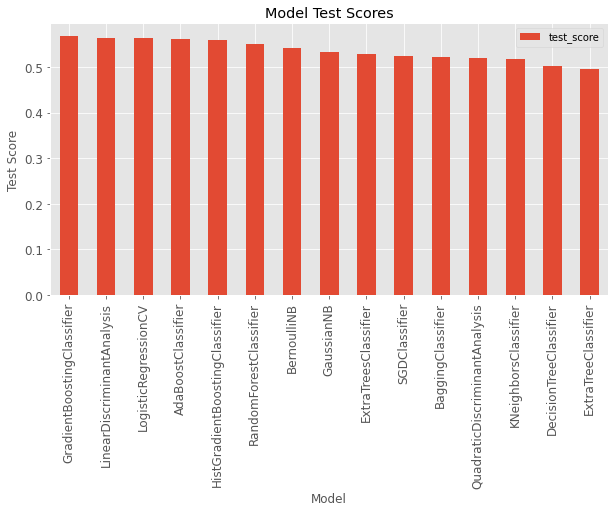

In [22]:
model_test_scores = pd.DataFrame(columns=['model', 'test_score'])

for model in models:
    model_name = model[0]
    model_test_score = model[-1]
    model_test_scores = model_test_scores.append(pd.DataFrame({'model': [model_name], 'test_score': [model_test_score]}))

# plot model test scores
ax = model_test_scores.plot(x='model', y='test_score', kind='bar', figsize=(10, 5))
ax.set_title('Model Test Scores')
ax.set_xlabel('Model')
ax.set_ylabel('Test Score')
plt.xticks(rotation=90)
ax.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.63      0.99      0.78      4964
           1       0.38      0.01      0.01      2857

    accuracy                           0.63      7821
   macro avg       0.50      0.50      0.39      7821
weighted avg       0.54      0.63      0.50      7821



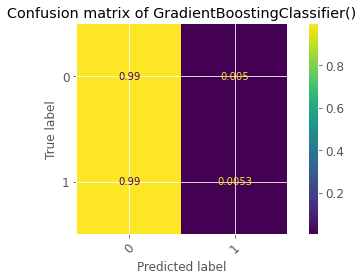

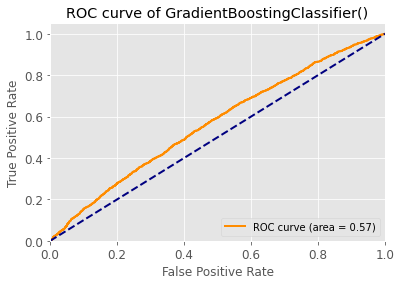

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      4964
           1       1.00      0.00      0.00      2857

    accuracy                           0.63      7821
   macro avg       0.82      0.50      0.39      7821
weighted avg       0.77      0.63      0.49      7821



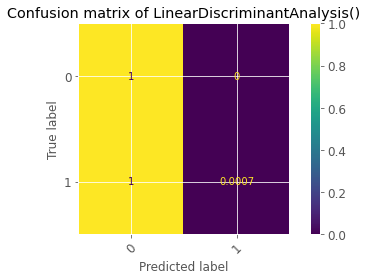

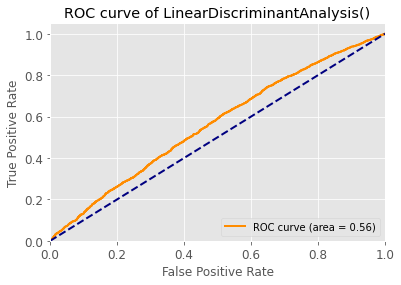

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      4964
           1       0.00      0.00      0.00      2857

    accuracy                           0.63      7821
   macro avg       0.32      0.50      0.39      7821
weighted avg       0.40      0.63      0.49      7821



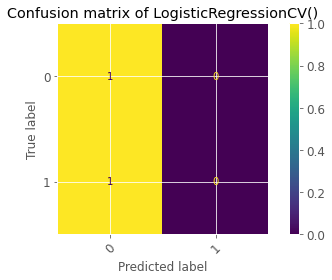

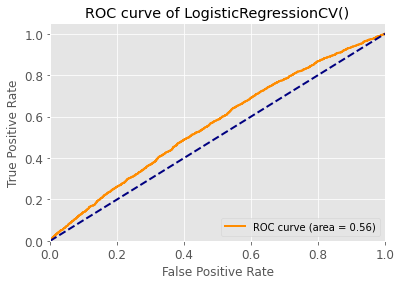

              precision    recall  f1-score   support

           0       0.64      0.98      0.77      4964
           1       0.54      0.04      0.07      2857

    accuracy                           0.64      7821
   macro avg       0.59      0.51      0.42      7821
weighted avg       0.60      0.64      0.52      7821



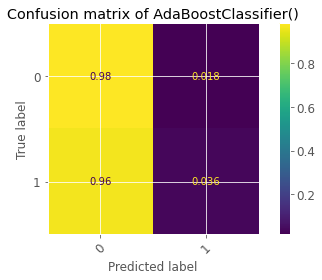

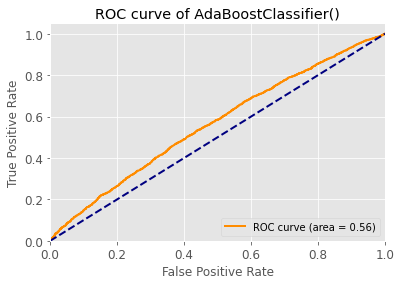

              precision    recall  f1-score   support

           0       0.64      0.99      0.77      4964
           1       0.43      0.01      0.02      2857

    accuracy                           0.63      7821
   macro avg       0.53      0.50      0.40      7821
weighted avg       0.56      0.63      0.50      7821



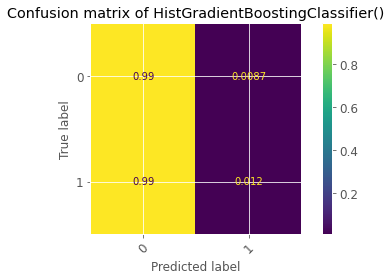

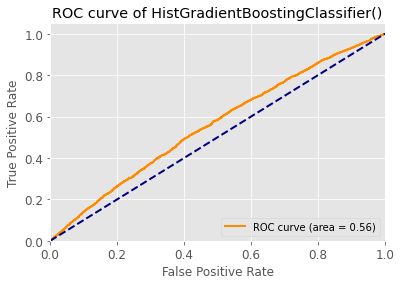

              precision    recall  f1-score   support

           0       0.64      0.95      0.77      4964
           1       0.45      0.07      0.12      2857

    accuracy                           0.63      7821
   macro avg       0.55      0.51      0.44      7821
weighted avg       0.57      0.63      0.53      7821



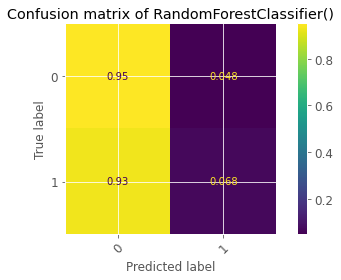

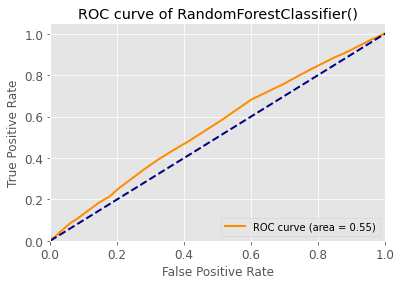

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      4964
           1       0.00      0.00      0.00      2857

    accuracy                           0.63      7821
   macro avg       0.32      0.50      0.39      7821
weighted avg       0.40      0.63      0.49      7821



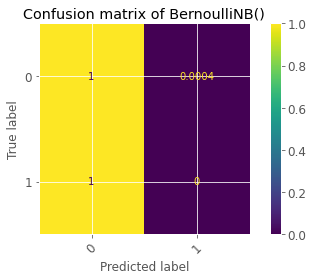

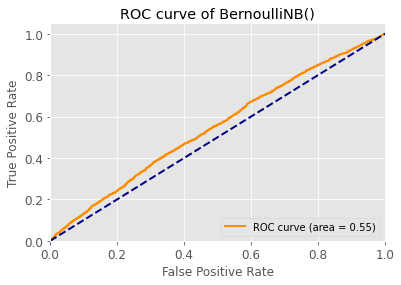

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      4964
           1       0.42      0.29      0.34      2857

    accuracy                           0.60      7821
   macro avg       0.54      0.53      0.53      7821
weighted avg       0.57      0.60      0.57      7821



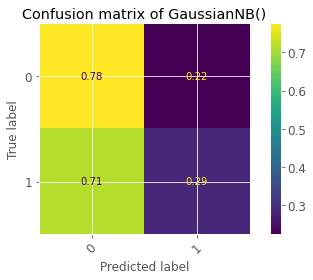

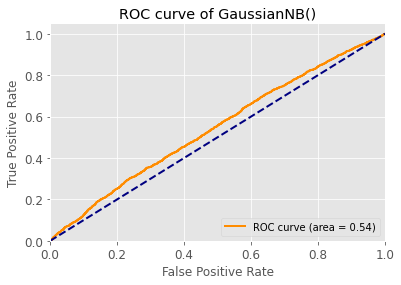

              precision    recall  f1-score   support

           0       0.64      0.92      0.76      4964
           1       0.41      0.09      0.15      2857

    accuracy                           0.62      7821
   macro avg       0.53      0.51      0.45      7821
weighted avg       0.56      0.62      0.53      7821



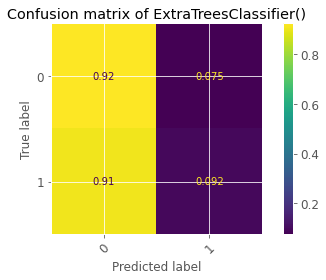

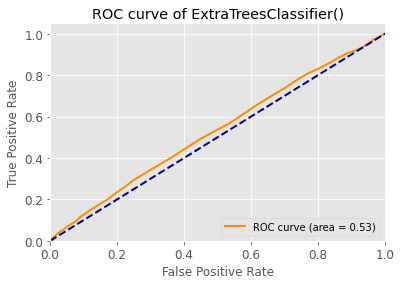

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      4964
           1       0.17      0.00      0.00      2857

    accuracy                           0.63      7821
   macro avg       0.40      0.50      0.39      7821
weighted avg       0.46      0.63      0.49      7821



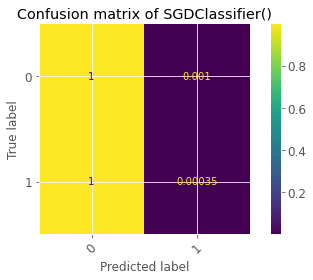

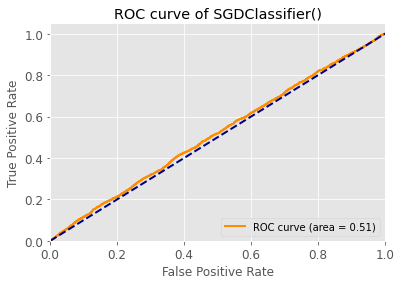

In [24]:
top_models = models[:10]
model_grid_searches = [best_model[-2] for best_model in top_models]
model_names = [best_model[1] for best_model in top_models]

models_evaluation(model_grid_searches, X_test_preprocessed, y_test_preprocessed, titles=model_names)

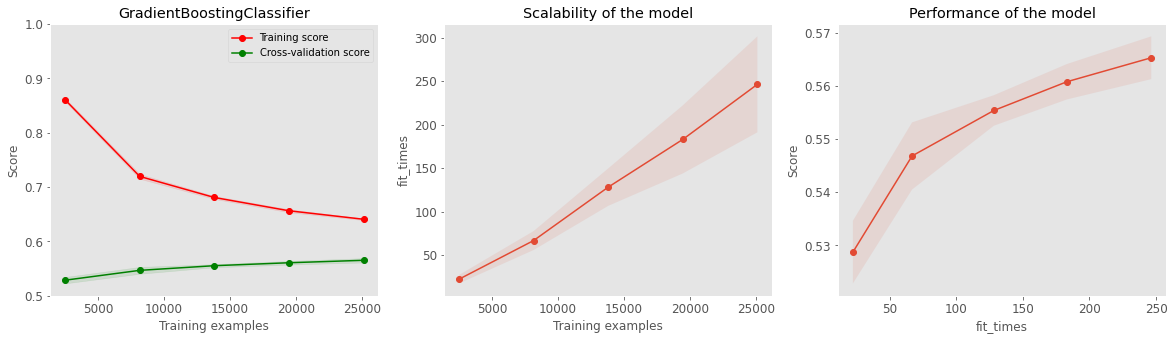

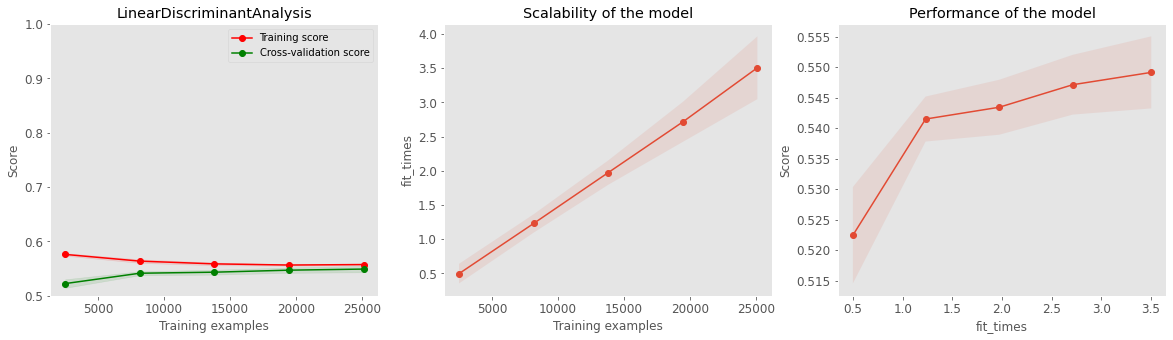

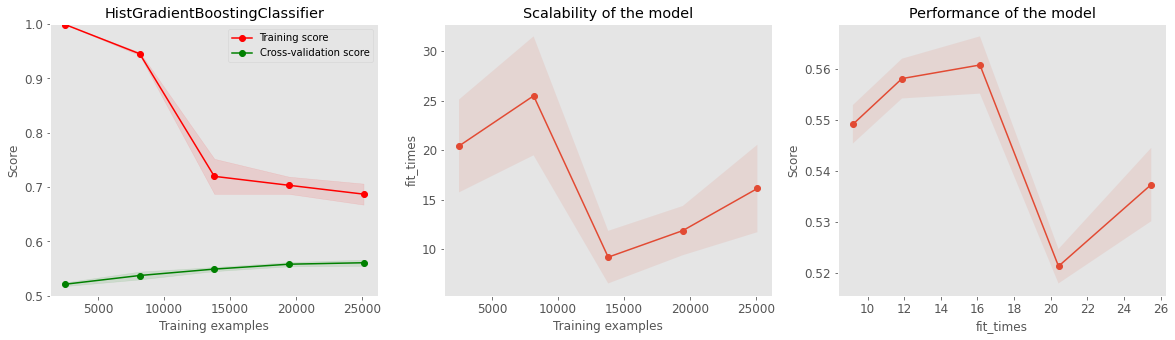

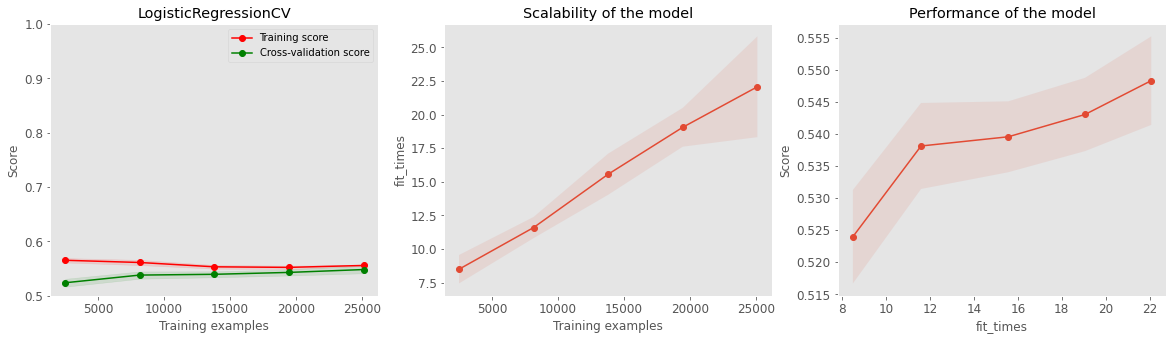

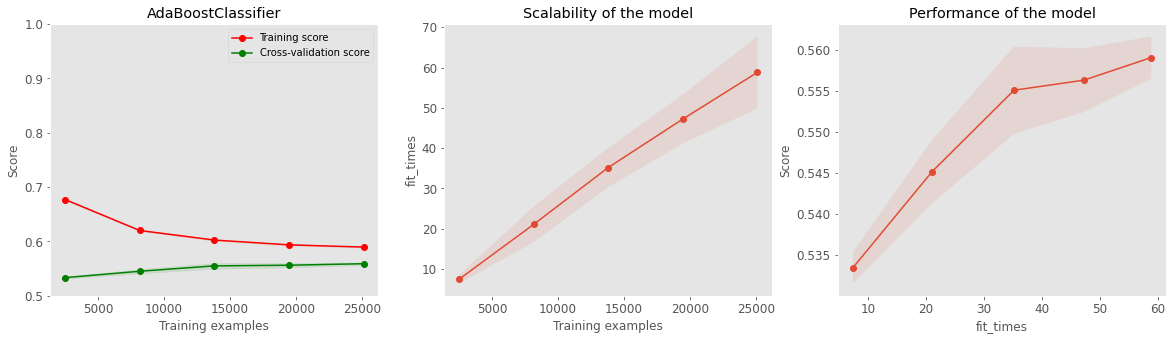

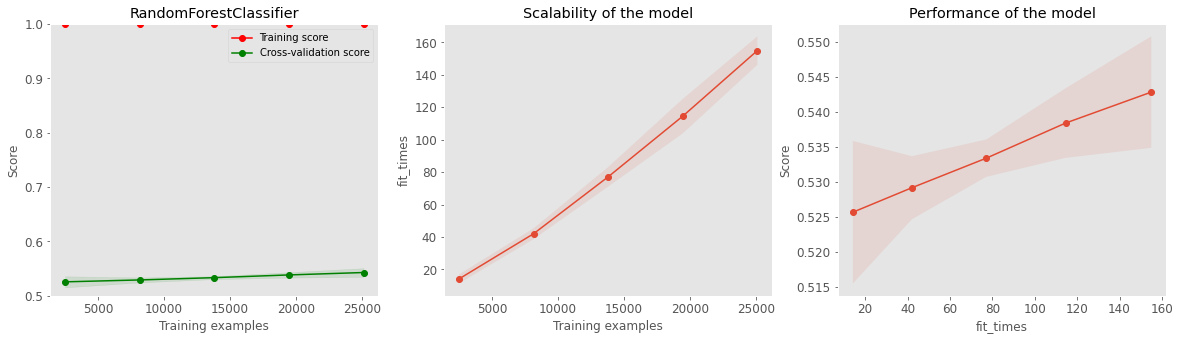

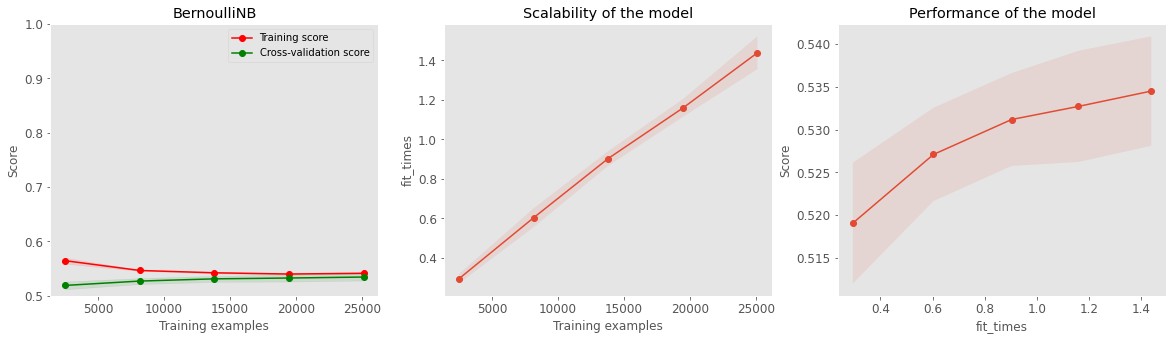

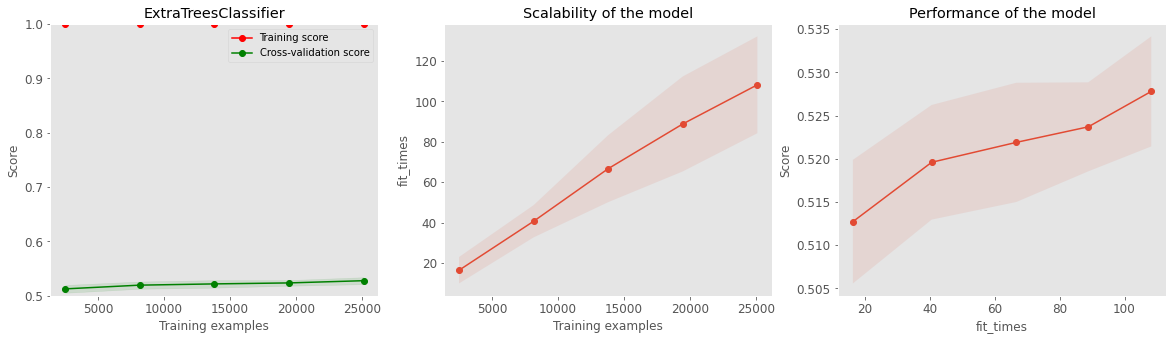

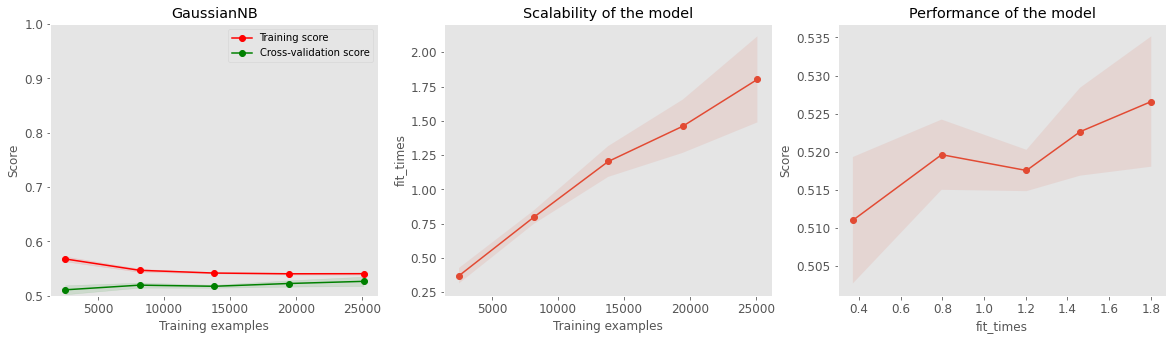

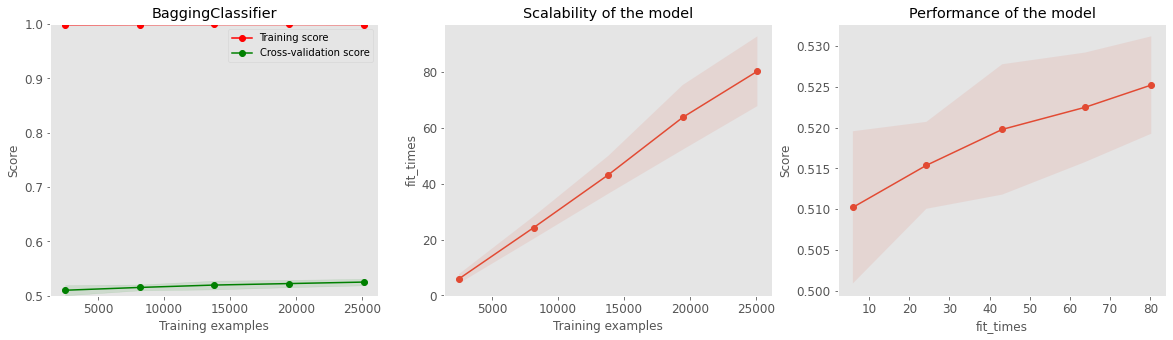

In [42]:
# plot learning curves
for model in top_models:
    model_name = model[0]
    model_grid_search = model[-2]
    plot_learning_curve(model_grid_search, X_train_preprocessed, y_train_preprocessed,
                        title=model_name, scoring='roc_auc', ylim=(0.5, 1.0))

## A clever but less informative approach

### [TPOT](http://epistasislab.github.io/tpot/) - An ML Engineer's approach

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

[<img src="https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-ml-pipeline.png">](http://google.com.au/)

In [24]:
from tpot import TPOTClassifier

clf = TPOTClassifier(generations=10, population_size=160, mutation_rate=.7, crossover_rate=.3, verbosity=3, scoring='roc_auc', cv=5, n_jobs=-1, early_stop=5, max_eval_time_mins=15)
clf.fit(X_train_preprocessed, y_train_preprocessed)
print(clf.score(X_test_preprocessed, y_test_preprocessed))
clf.export('model.py')

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/1760 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', l

In [25]:
clf.fitted_pipeline_

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=SGDClassifier(alpha=0.0, eta0=0.1,
                                                           l1_ratio=0.5,
                                                           learning_rate='constant',
                                                           loss='perceptron',
                                                           penalty='elasticnet'))),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features=0.7500000000000001,
                                            min_samples_leaf=18,
                                            subsample=0.25))])

In [27]:
evaluated_clfs = clf.evaluated_individuals_

import pprint
# find top 5 classifiers with highest internal_cv_score
top_clfs = dict(sorted(evaluated_clfs.items(), key=lambda x: x[1]['internal_cv_score'], reverse=True)[:5])
for (key, values) in top_clfs.items():
    print(f"classifier : {key}")
    for value in values:
        if value == 'internal_cv_score':
            print("\t", end="")
        print(f"{value} : {values[value]}")

    print("--------------------------------------------------------------------------------")

classifier : GradientBoostingClassifier(SGDClassifier(input_matrix, SGDClassifier__alpha=0.0, SGDClassifier__eta0=0.1, SGDClassifier__fit_intercept=True, SGDClassifier__l1_ratio=0.5, SGDClassifier__learning_rate=constant, SGDClassifier__loss=perceptron, SGDClassifier__penalty=elasticnet, SGDClassifier__power_t=0.5), GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=8, GradientBoostingClassifier__max_features=0.7500000000000001, GradientBoostingClassifier__min_samples_leaf=18, GradientBoostingClassifier__min_samples_split=2, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.25)
generation : 10
mutation_count : 2
crossover_count : 3
predecessor : ('GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=8, GradientBoostingClassifier__max_features=0.7500000000000001, GradientBoostingClassifier__min_samples_leaf=18, GradientBoostingClassifier__min

In [22]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# # Average CV score on the training set was: 0.5662000812417779
# exported_pipeline = XGBClassifier(learning_rate=0.01, max_depth=8, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.3, verbosity=0)

# Average CV score on the training set was: 0.5720399403745379
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDClassifier(alpha=0.0, eta0=0.1, fit_intercept=True, l1_ratio=0.5, learning_rate="constant", loss="perceptron", penalty="elasticnet", power_t=0.5)),
    GradientBoostingClassifier(learning_rate=0.001, max_depth=8, max_features=0.7500000000000001, min_samples_leaf=18, min_samples_split=2, n_estimators=100, subsample=0.25)
)


exported_pipeline.fit(X_train_preprocessed, y_train_preprocessed)
results = exported_pipeline.predict(X_test_preprocessed)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.56      0.61      4964
           1       0.41      0.54      0.46      2857

    accuracy                           0.55      7821
   macro avg       0.54      0.55      0.54      7821
weighted avg       0.58      0.55      0.56      7821



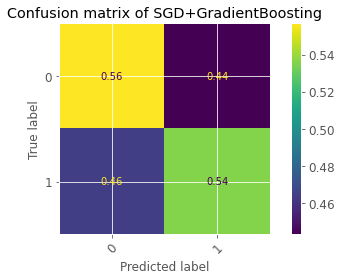

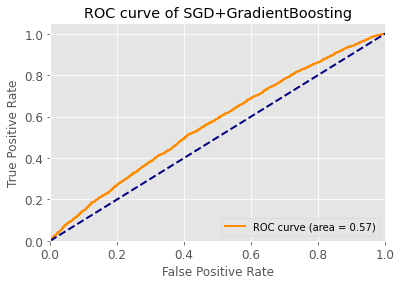

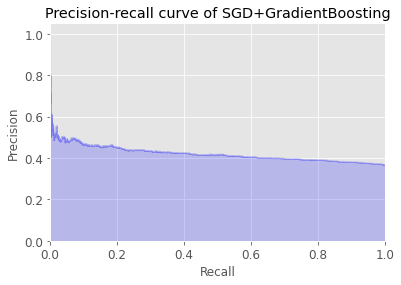

In [98]:
import sys
# sys.path.append( '../' )

from models.model_selection import models_building, hyperparameters_validation, models_evaluation, plot_learning_curve, model_evaluation


search = GridSearchCV(exported_pipeline, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1, param_grid={})
search.fit(X_train_preprocessed, y_train_preprocessed)

# models_evaluation([exported_pipeline], X_test_preprocessed, y_test_preprocessed, titles=['SGD+GradientBoosting'])
model_evaluation(search, X_test_preprocessed, y_test_preprocessed, title='SGD+GradientBoosting', prediction_threshold=.365)

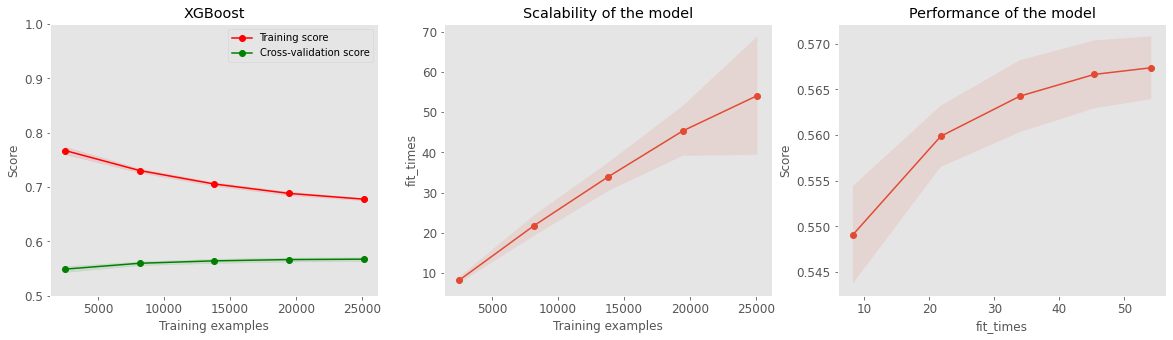

In [24]:
plot_learning_curve(search, X_train_preprocessed, y_train_preprocessed,
                        title='XGBoost', scoring='roc_auc', ylim=(0.5, 1.0))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.57      0.62      4978
           1       0.41      0.53      0.46      2866

    accuracy                           0.55      7844
   macro avg       0.55      0.55      0.54      7844
weighted avg       0.58      0.55      0.56      7844



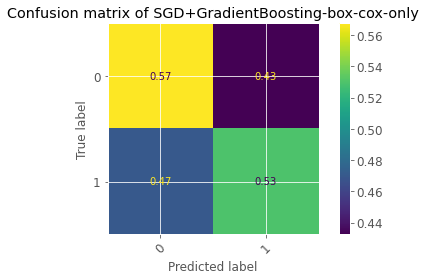

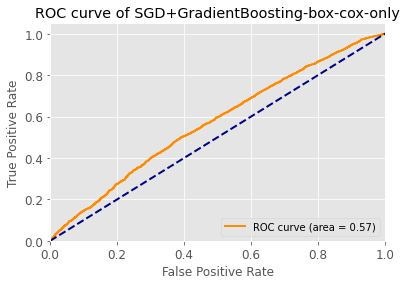

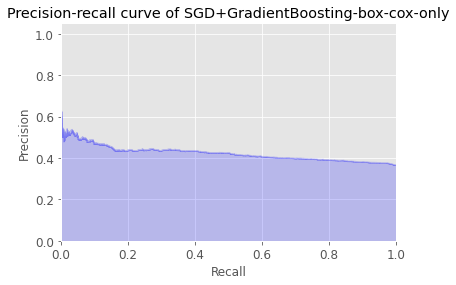

In [99]:
class PreProcessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, show_impute=False, inplace=False):
        self.show_impute = show_impute
        self.inplace = inplace
        self.col_sig, self.col_pow, self.loudness = cols
        self.cols = self.col_sig + self.col_pow
        # self.inv_sigmoid = FunctionTransformer(lambda x: np.log(x / (1-x)))
        self.loudness_transformer = FunctionTransformer(lambda x: np.log1p(-x))
        
    def fit(self, X, y=None):
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)
        
        self.scaler = MinMaxScaler(feature_range=(0+1e-6, 1-1e-6)).fit(X[self.col_sig], y=y)
        
        X_tmp = X[self.col_sig+self.col_pow].copy()
        X_tmp[self.col_sig] = self.scaler.transform(X_tmp[self.col_sig])
        # X_tmp[self.col_sig] = self.inv_sigmoid.fit_transform(X_tmp[self.col_sig], y=y)
        
        self.transformer = PowerTransformer().fit(X_tmp)
        
        return self
    
    def transform(self, X):

        if not self.inplace:
            X = X.copy()


        X[self.col_sig] = self.scaler.transform(X[self.col_sig])
        # X[self.col_sig] = self.inv_sigmoid.fit_transform(X[self.col_sig])
        # Box-Cox transformation
        X[self.col_sig+self.col_pow] = self.transformer.transform(X[self.col_sig+self.col_pow])
        X[self.loudness] = self.loudness_transformer.fit_transform(X[self.loudness])
        
        return X

transformer = PreProcessorTransformer([col_sig, col_pow, 'loudness'])

preprocessor_pipe = Pipeline([
    ("na-imputation", imputer),
    ("transformation", transformer),
])

preprocessor_pipe.fit(X_train_full)
X_preprocessed = preprocessor_pipe.transform(X_train_full)

outlier_remover = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
mask = outlier_remover.fit_predict(X_preprocessed, y_train_full)
mask = mask != -1
outlier_remover.fit(X_preprocessed, y_train_full)
X_train_preprocessed, y_train_preprocessed = X_preprocessed.iloc[mask, :], y_train_full[mask]
X_train_preprocessed = pd.get_dummies(X_train_preprocessed)

X_test_preprocessed = preprocessor_pipe.transform(X_test)
isna = X_test_preprocessed.apply(lambda x: x.isnull().sum() > 0, axis=1).values
X_test_preprocessed = X_test_preprocessed.loc[~isna, :]
y_test_preprocessed = y_test[~isna]

outlier_remover = LocalOutlierFactor(n_neighbors=20, contamination=0.02, novelty=True)
outlier_remover.fit(X_preprocessed, y_train_full)
mask = outlier_remover.predict(X_test_preprocessed)
mask = mask != -1
X_test_preprocessed, y_test_preprocessed = X_test_preprocessed.iloc[mask, :], y_test_preprocessed[mask]
X_test_preprocessed = pd.get_dummies(X_test_preprocessed)


search = GridSearchCV(exported_pipeline, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1, param_grid={})
search.fit(X_train_preprocessed, y_train_preprocessed)

model_evaluation(search, X_test_preprocessed, y_test_preprocessed, title='SGD+GradientBoosting-box-cox-only', prediction_threshold=.365)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.55      0.61      4980
           1       0.42      0.56      0.48      2862

    accuracy                           0.55      7842
   macro avg       0.55      0.55      0.54      7842
weighted avg       0.59      0.55      0.56      7842



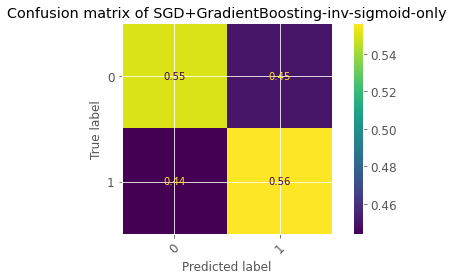

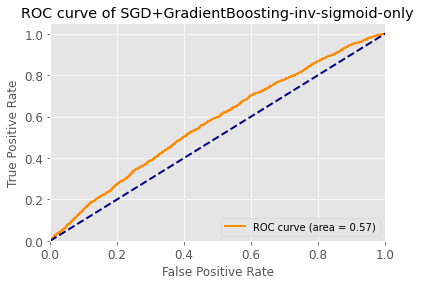

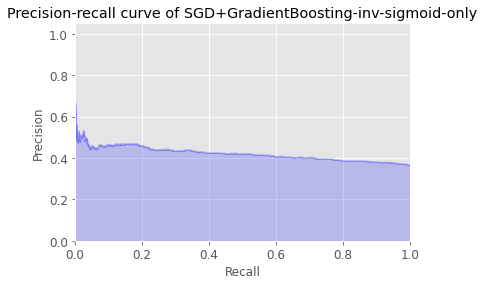

In [100]:
class PreProcessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, show_impute=False, inplace=False):
        self.show_impute = show_impute
        self.inplace = inplace
        self.col_sig, self.col_pow, self.loudness = cols
        self.cols = self.col_sig + self.col_pow
        self.inv_sigmoid = FunctionTransformer(lambda x: np.log(x / (1-x)))
        self.loudness_transformer = FunctionTransformer(lambda x: np.log1p(-x))
        
    def fit(self, X, y=None):
        if type(X) is dict:
            X = X.get('X')
            y = X.get('y', y)
        
        self.scaler = MinMaxScaler(feature_range=(0+1e-6, 1-1e-6)).fit(X[self.col_sig], y=y)
        
        X_tmp = X[self.col_sig+self.col_pow].copy()
        X_tmp[self.col_sig] = self.scaler.transform(X_tmp[self.col_sig])
        X_tmp[self.col_sig] = self.inv_sigmoid.fit_transform(X_tmp[self.col_sig], y=y)
        
        return self
    
    def transform(self, X):

        if not self.inplace:
            X = X.copy()


        X[self.col_sig] = self.scaler.transform(X[self.col_sig])
        X[self.col_sig] = self.inv_sigmoid.fit_transform(X[self.col_sig])
        X[self.loudness] = self.loudness_transformer.fit_transform(X[self.loudness])
        
        return X

transformer = PreProcessorTransformer([col_sig, col_pow, 'loudness'])

preprocessor_pipe = Pipeline([
    ("na-imputation", imputer),
    ("transformation", transformer),
])

preprocessor_pipe.fit(X_train_full)
X_preprocessed = preprocessor_pipe.transform(X_train_full)

outlier_remover = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
mask = outlier_remover.fit_predict(X_preprocessed, y_train_full)
mask = mask != -1
outlier_remover.fit(X_preprocessed, y_train_full)
X_train_preprocessed, y_train_preprocessed = X_preprocessed.iloc[mask, :], y_train_full[mask]
X_train_preprocessed = pd.get_dummies(X_train_preprocessed)

X_test_preprocessed = preprocessor_pipe.transform(X_test)
isna = X_test_preprocessed.apply(lambda x: x.isnull().sum() > 0, axis=1).values
X_test_preprocessed = X_test_preprocessed.loc[~isna, :]
y_test_preprocessed = y_test[~isna]

outlier_remover = LocalOutlierFactor(n_neighbors=20, contamination=0.02, novelty=True)
outlier_remover.fit(X_preprocessed, y_train_full)
mask = outlier_remover.predict(X_test_preprocessed)
mask = mask != -1
X_test_preprocessed, y_test_preprocessed = X_test_preprocessed.iloc[mask, :], y_test_preprocessed[mask]
X_test_preprocessed = pd.get_dummies(X_test_preprocessed)


search = GridSearchCV(exported_pipeline, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1, param_grid={})
search.fit(X_train_preprocessed, y_train_preprocessed)

model_evaluation(search, X_test_preprocessed, y_test_preprocessed, title='SGD+GradientBoosting-inv-sigmoid-only', prediction_threshold=.365)